Halyna Trush. Contact Information Phone: +380954200758 Email: frolova.galka@gmail.com LinkedIn: https://www.linkedin.com/in/halyna-trush/


**Mountain NER — Fine-tuning BERT for Named Entity Recognition**

This notebook fine-tunes a BERT-based model (bert-base-cased) to recognize mountain names using a CoNLL-formatted dataset.
The workflow includes data preparation, tokenization, fine-tuning, evaluation, and an inference demo.

Steps covered:

*   Install and import required libraries

*   Load and preprocess train.txt, valid.txt, and test.txt

*   Tokenize data and align labels

*   Fine-tune the model (bert-base-cased)

*   Evaluate with entity-level metrics (precision, recall, F1) using seqeval

*   Save the model and tokenizer

*   Run an interactive inference demonstration inference.ipynb

In [1]:
# Installing basic libraries for NER tasks.
# Transformers is used to load and fine-tune BERT-based models.
# Seqeval is used to calculate evaluation metrics (precision, recall, F1) for named entity recognition.
%pip -q install "transformers==4.57.1" "seqeval==1.2.2"
import numpy as np, transformers, torch
# Set up dataset directory
from pathlib import Path
from transformers import AutoTokenizer
import torch
from typing import List, Tuple, Dict, Any
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from torch.optim import AdamW
from tqdm.auto import tqdm
from google.colab import drive
import shutil
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Checking library versions to keep the environment consistent.
print("✅ NumPy:", np.__version__)
print("✅ Transformers:", transformers.__version__)
print("✅ Torch:", torch.__version__)

# Optionally, you can check if a GPU is available.
# print("GPU available:", torch.cuda.is_available())

✅ NumPy: 2.0.2
✅ Transformers: 4.57.1
✅ Torch: 2.8.0+cu126


In [3]:
DATA_DIR = Path("/content/data/mountain_ner_conll")
DATA_DIR.mkdir(parents=True, exist_ok=True)

!wget -q -O {DATA_DIR}/train.txt "https://drive.google.com/uc?export=download&id=1xjhinE4z0x1PNrEEnEpFsPBKm9dfgWU-"
!wget -q -O {DATA_DIR}/valid.txt "https://drive.google.com/uc?export=download&id=157dKfodZSj-fc_NABihbka2xqKpFmUmU"
!wget -q -O {DATA_DIR}/test.txt  "https://drive.google.com/uc?export=download&id=1bdjnBDPwMP3R-yDulVifEuhT0wvW_kmB"

# Basic existence + size checks
for name in ["train.txt", "valid.txt", "test.txt"]:
    p = DATA_DIR / name
    if not p.exists() or p.stat().st_size == 0:
        raise FileNotFoundError(f"{name}: not downloaded or file is empty.")

# Quick sanity read to catch encoding/format issues early
def sanity_read(path, n=3):
    try:
        with open(path, "r", encoding="utf-8") as f:
            _ = [next(f) for _ in range(n)]
    except StopIteration:
        raise ValueError(f"{path.name}: file is too short or empty.")
    except UnicodeDecodeError as e:
        raise UnicodeDecodeError(e.encoding, e.object, e.start, e.end, f"{path.name}: encoding error")

for name in ["train.txt", "valid.txt", "test.txt"]:
    sanity_read(DATA_DIR / name)

print("OK:", DATA_DIR.resolve())
!ls -lh {DATA_DIR}



OK: /content/data/mountain_ner_conll
total 108K
-rw-r--r-- 1 root root 15K Nov  3 11:34 test.txt
-rw-r--r-- 1 root root 75K Nov  3 20:28 train.txt
-rw-r--r-- 1 root root 15K Nov  3 11:34 valid.txt


In [5]:
def read_conll(path: Path):
    # Reads a file in CoNLL format (token and tag per line, empty line = sentence separator)
    sents, toks, tags = [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                # Sentence boundary
                if toks:
                    sents.append((toks, tags))
                    toks, tags = [], []
            else:
                parts = line.split()
                # Skip malformed lines that don't have exactly 2 elements
                if len(parts) != 2:
                    continue
                tok, tag = parts
                toks.append(tok)
                tags.append(tag)
    if toks:
        sents.append((toks, tags))
    return sents

DATA_DIR = Path("/content/data/mountain_ner_conll")

# Reading train, validation and test splits
train_pairs = read_conll(DATA_DIR / "train.txt")
valid_pairs = read_conll(DATA_DIR / "valid.txt")
test_pairs  = read_conll(DATA_DIR / "test.txt")

# Display basic info about loaded data
print(f"Train: {len(train_pairs)} | Valid: {len(valid_pairs)} | Test: {len(test_pairs)}")
print("Sample:", list(zip(train_pairs[0][0][:10], train_pairs[0][1][:10])))



Train: 900 | Valid: 180 | Test: 180
Sample: [('Sunrise', 'O'), ('from', 'O'), ('the', 'O'), ('slopes', 'O'), ('of', 'O'), ('Phu', 'B-MOUNT'), ('Si', 'I-MOUNT'), ('Lung', 'I-MOUNT'), ('was', 'O'), ('unforgettable', 'O')]


In [6]:
# Model and label setup
MODEL_NAME = "bert-base-cased"

# Define label set and mappings between labels and IDs
LABEL_LIST = ["O", "B-MOUNT", "I-MOUNT"]
LABEL2ID = {l: i for i, l in enumerate(LABEL_LIST)}
ID2LABEL = {i: l for i, l in enumerate(LABEL_LIST)}

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_tokens_and_align_labels(tokens, ner_tags):
    """
    Aligns word-level NER tags with subword tokens
    and converts them into tensors for model training.
    """
    # Check input lengths to avoid misalignment
    if len(tokens) != len(ner_tags):
        raise ValueError("Number of tokens and NER tags must match.")

    # Tokenize input text (split into subwords)
    enc = tokenizer(tokens, is_split_into_words=True, truncation=True, return_tensors="pt")
    word_ids = enc.word_ids(0)

    labels = []
    prev_wid = None
    for wid in word_ids:
        if wid is None:
            labels.append(-100)  # ignore special tokens ([CLS], [SEP], padding)
        else:
            lab = ner_tags[wid]
            # convert 'B-' to 'I-' for subwords of the same word
            if prev_wid == wid and lab.startswith("B-"):
                lab = "I-" + lab.split("-", 1)[1]
            labels.append(LABEL2ID[lab])
            prev_wid = wid

    # Remove batch dimension (batch size = 1)
    for k in enc:
        enc[k] = enc[k].squeeze(0)

    labels = torch.tensor(labels, dtype=torch.long)
    return enc, labels

print("Tokenizer ready:", MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Tokenizer ready: bert-base-cased


In [7]:
class ConllTorchDataset(Dataset):
    """Stores (tokens, tags) pairs, validates input, and pre-tokenizes examples."""
    def __init__(self, pairs: List[Tuple[List[str], List[str]]]):
        self.items: List[Dict[str, Any]] = []

        for i, (tokens, tags) in enumerate(pairs):
            # Basic format checks
            if len(tokens) != len(tags):
                raise ValueError(f"Sentence {i}: tokens and tags length mismatch ({len(tokens)} vs {len(tags)}).")
            for t in tags:
                if t not in LABEL2ID:
                    raise ValueError(f"Sentence {i}: unknown tag '{t}'.")

            # Pre-tokenize and align labels once to speed up training
            enc, labels = encode_tokens_and_align_labels(tokens, tags)
            enc["labels"] = labels
            self.items.append(enc)

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        return self.items[idx]

# Pads and batches variable-length token sequences for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

ds_train = ConllTorchDataset(train_pairs)
ds_valid = ConllTorchDataset(valid_pairs)
ds_test  = ConllTorchDataset(test_pairs)

# Reproducibility and basic performance tweaks
torch.manual_seed(42)
use_gpu = torch.cuda.is_available()
num_workers = 2 if use_gpu else 0   # modest parallelism is usually enough in Colab
pin_memory = use_gpu

# If you hit OOM, lower batch_size to 8 or 4
loader_train = DataLoader(
    ds_train, batch_size=16, shuffle=True, collate_fn=data_collator,
    num_workers=num_workers, pin_memory=pin_memory, generator=torch.Generator().manual_seed(42)
)
loader_valid = DataLoader(
    ds_valid, batch_size=16, shuffle=False, collate_fn=data_collator,
    num_workers=num_workers, pin_memory=pin_memory
)
loader_test = DataLoader(
    ds_test, batch_size=16, shuffle=False, collate_fn=data_collator,
    num_workers=num_workers, pin_memory=pin_memory
)

print("✅ Datasets:", len(ds_train), len(ds_valid), len(ds_test))


✅ Datasets: 900 180 180


In [10]:
# Load model for token classification with custom label mapping
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL_LIST),
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

# Move to device and set optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

def run_epoch(loader, train=True):
    """One epoch over a dataloader; returns average loss."""
    model.train() if train else model.eval()
    total = 0.0
    for batch in tqdm(loader, disable=False, desc="Train" if train else "Valid"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.set_grad_enabled(train):
            out = model(**batch)        # provides .loss and .logits
            loss = out.loss
            if train:
                optimizer.zero_grad()   # standard gradient reset
                loss.backward()
                optimizer.step()
        total += float(loss.detach().cpu())
    return total / max(1, len(loader))

EPOCHS = 3
for ep in range(1, EPOCHS + 1):
    tr = run_epoch(loader_train, True)
    va = run_epoch(loader_valid, False)
    print(f"Epoch {ep}: train_loss={tr:.4f} | valid_loss={va:.4f}")

print("✅ Training finished")



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1: train_loss=0.2148 | valid_loss=0.0059


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2: train_loss=0.0018 | valid_loss=0.0002


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Valid:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0006 | valid_loss=0.0002
✅ Training finished


In [11]:
# Create directory for model artifacts
SAVE_DIR = Path("./artifacts/model")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Basic check to ensure model has been trained before saving
if hasattr(model, "state_dict") and len(model.state_dict()) > 0:
    model.save_pretrained(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)
    print("✅ Saved to:", SAVE_DIR.resolve())
else:
    print("⚠️ Model weights not found or model not trained. Skipping save.")


✅ Saved to: /content/artifacts/model


In [12]:
# === Save fine-tuned model and tokenizer to Google Drive ===
# Mount Google Drive
drive.mount('/content/drive')

# Define source (local) and destination (Drive) directories
src_dir = Path("./artifacts/model")
dst_dir = Path("/content/drive/MyDrive/mountain_ner_model")

# Copy model folder to Drive
if src_dir.exists() and any(src_dir.iterdir()):
    shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
    print(f"✅ Model saved to Google Drive at: {dst_dir}")
    print("🔗 You can now share this folder via 'Anyone with the link' → Viewer access.")
else:
    print("⚠️ Model folder not found or empty. Please check training step.")


Mounted at /content/drive
✅ Model saved to Google Drive at: /content/drive/MyDrive/mountain_ner_model
🔗 You can now share this folder via 'Anyone with the link' → Viewer access.


In [13]:
def predict_labels(loader):
    """Runs inference and reconstructs true/pred label sequences using attention masks and -100 labels."""
    model.eval()
    all_true, all_pred = [], []
    kept_tokens = 0  # how many tokens passed mask & label filtering

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            # Keep CPU copies for label/mask-based filtering
            labels = batch["labels"].cpu().numpy()
            mask   = batch["attention_mask"].cpu().numpy()

            # Move inputs to device for forward pass
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**{k: v for k, v in batch.items() if k != "labels"}).logits
            preds  = logits.argmax(-1).cpu().numpy()

            # Rebuild sequences; skip padding/special tokens
            for y_true, y_pred, m in zip(labels, preds, mask):
                true_seq, pred_seq = [], []
                for t, p, mm in zip(y_true, y_pred, m):
                    if mm == 0 or t == -100:
                        continue
                    true_seq.append(ID2LABEL[int(t)])
                    pred_seq.append(ID2LABEL[int(p)])
                kept_tokens += len(true_seq)
                all_true.append(true_seq)
                all_pred.append(pred_seq)

    # Basic sanity check to catch empty sequences (would distort metrics)
    if kept_tokens == 0:
        raise RuntimeError("No tokens remained after masking. Check attention_mask and label alignment.")

    # Free cache after the whole evaluation pass
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return all_true, all_pred

# ----- Validation metrics (same compact format) -----
y_true_val, y_pred_val = predict_labels(loader_valid)
p_val = precision_score(y_true_val, y_pred_val)
r_val = recall_score(y_true_val, y_pred_val)
f_val = f1_score(y_true_val, y_pred_val)
print("VALID  P/R/F1:", p_val, r_val, f_val)
print("\nVALID report:\n", classification_report(y_true_val, y_pred_val, digits=4))

# ----- Test metrics (same compact format) -----
y_true_test, y_pred_test = predict_labels(loader_test)
p_tst = precision_score(y_true_test, y_pred_test)
r_tst = recall_score(y_true_test, y_pred_test)
f_tst = f1_score(y_true_test, y_pred_test)
print("\nTEST   P/R/F1:", p_tst, r_tst, f_tst)
print("\nTEST report:\n", classification_report(y_true_test, y_pred_test, digits=4))


Evaluating:   0%|          | 0/12 [00:50<?, ?it/s]

VALID  P/R/F1: 1.0 1.0 1.0

VALID report:
               precision    recall  f1-score   support

       MOUNT     1.0000    1.0000    1.0000        90

   micro avg     1.0000    1.0000    1.0000        90
   macro avg     1.0000    1.0000    1.0000        90
weighted avg     1.0000    1.0000    1.0000        90



Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


TEST   P/R/F1: 0.9565217391304348 0.9777777777777777 0.967032967032967

TEST report:
               precision    recall  f1-score   support

       MOUNT     0.9565    0.9778    0.9670        90

   micro avg     0.9565    0.9778    0.9670        90
   macro avg     0.9565    0.9778    0.9670        90
weighted avg     0.9565    0.9778    0.9670        90



In [16]:

def ner_predict(sentence: str, model_dir: str = "./artifacts/model", max_length: int = 128):
    """
    Runs word-level NER inference for a single sentence and returns:
      - tokens: original whitespace-split words,
      - labels: predicted BIO tags aligned at word level,
      - ents:   reconstructed 'MOUNT' entity spans (strings).
    """

    # --- Load tokenizer & model; prefer labels from model config to avoid mismatch ---
    tok = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    mdl = AutoModelForTokenClassification.from_pretrained(model_dir)
    mdl.eval()

    # --- Pick device automatically (GPU if available) ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mdl.to(device)

    # --- Prepare inputs: split into words and keep word_ids mapping via fast tokenizer ---
    words = sentence.split()
    enc = tok(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=False,
    ).to(device)

    # --- Forward pass (no grad, inference-friendly context) ---
    with torch.inference_mode():
        logits = mdl(**enc).logits  # [1, seq_len, num_labels]

    # --- Convert to predicted label ids ---
    pred_ids = logits.argmax(dim=-1)[0].detach().cpu().tolist()

    # --- Map ids to label strings from model config (safer than external LABEL_LIST) ---
    id2label = mdl.config.id2label
    word_ids = enc.word_ids(0)  # list of length seq_len mapping subtoken->word_index (or None)

    # --- Reduce subtoken predictions to one label per *word* (first subtoken policy) ---
    tokens, labels = [], []
    seen_word = set()
    for pos, wid in enumerate(word_ids):
        if wid is None:
            continue  # skip special tokens ([CLS], [SEP], padding)
        if wid in seen_word:
            continue  # keep only the first subtoken decision for a given word
        seen_word.add(wid)
        tokens.append(words[wid])
        labels.append(id2label[pred_ids[pos]])

    # --- Normalize possible 'I-' that start a span to 'B-' for readability (optional) ---
    for i, lab in enumerate(labels):
        if lab.startswith("I-") and (i == 0 or not labels[i-1].endswith(lab[2:])):
            labels[i] = "B-" + lab[2:]

    # --- Reconstruct 'MOUNT' entity spans from BIO sequence at word level ---
    ents, cur = [], []
    for w, lab in zip(tokens, labels):
        if lab == "B-MOUNT":
            if cur:
                ents.append(" ".join(cur))
                cur = []
            cur = [w]
        elif lab == "I-MOUNT":
            if cur:
                cur.append(w)
        else:
            if cur:
                ents.append(" ".join(cur))
                cur = []
    if cur:
        ents.append(" ".join(cur))

    return tokens, labels, ents

# Example:
print(ner_predict("We finally reached the base of Mount Crystal after a two-day trek"))


(['We', 'finally', 'reached', 'the', 'base', 'of', 'Mount', 'Crystal', 'after', 'a', 'two-day', 'trek'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNT', 'I-MOUNT', 'O', 'O', 'O', 'O'], ['Mount Crystal'])


In [17]:
def label_stats(pairs):
    """
    Compute tag frequency statistics for a list of (tokens, tags) pairs.
    Each element in `pairs` should be a tuple: (list_of_tokens, list_of_tags).

    Returns:
        pd.DataFrame with columns:
          - 'tag': tag name (e.g., O, B-MOUNT, I-MOUNT)
          - 'count': number of occurrences
          - 'ratio': relative frequency in the dataset
    """

    # Flatten all tags from all sentences into a single list
    counts = Counter(tag for _, tags in pairs for tag in tags)

    # Compute total number of tags
    total = sum(counts.values())
    if total == 0:
        return pd.DataFrame(columns=["tag", "count", "ratio"])

    # Create DataFrame with counts and relative ratios
    df = pd.DataFrame([
        {"tag": k, "count": v, "ratio": round(v / total, 5)}
        for k, v in counts.items()
    ])

    # Sort for consistent output order
    return df.sort_values("tag").reset_index(drop=True)

# Example usage:
label_stats(train_pairs)



,tag,count,ratio
0,B-MOUNT,586,0.06340
1,I-MOUNT,469,0.05074
2,O,8188,0.88586


Downloaded test.txt ✅


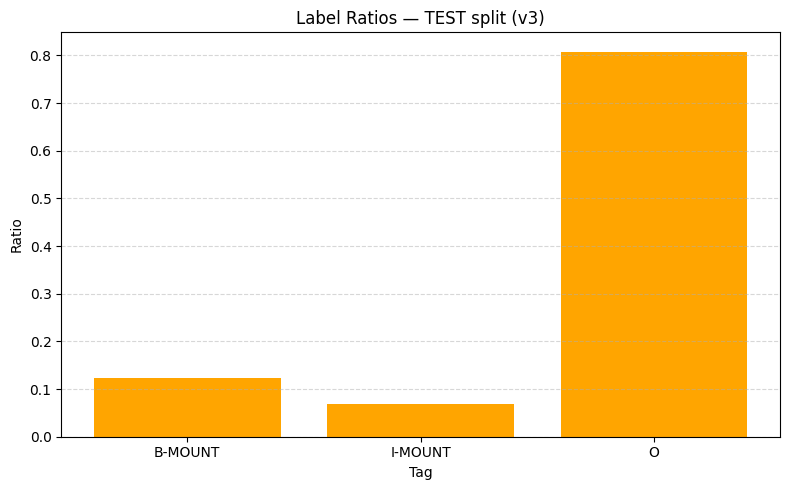

Saved figure as label_ratios_test_v3.png ✅


In [18]:
# === Ensure test.txt exists and build "Label Ratios — TEST split (v3)" ===
DATA_DIR = Path("/content/data/mountain_ner_conll_v3")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# ✅ Download test.txt if missing
if not (DATA_DIR / "test.txt").exists():
    !wget -q -O {DATA_DIR}/test.txt "https://drive.google.com/uc?export=download&id=1TMdq54L7C1qhYIccadSt7pygiJlA1k8g"
    print("Downloaded test.txt ✅")

# === Read tags from CoNLL file ===
def read_tags_conll(path: Path):
    tags = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            _, tag = line.split()
            tags.append(tag)
    return tags

tags = read_tags_conll(DATA_DIR / "test.txt")

# === Count tag frequencies ===
counts = Counter(tags)
total = sum(counts.values())
order = ["B-MOUNT", "I-MOUNT", "O"]
ratios = [counts[t] / total for t in order]

# === Plot label ratios ===
plt.figure(figsize=(8,5))
plt.bar(order, ratios, color="orange")
plt.title("Label Ratios — TEST split (v3)")
plt.xlabel("Tag")
plt.ylabel("Ratio")
plt.grid(True, axis="y", linestyle="--", linewidth=0.8, alpha=0.5)
plt.tight_layout()

# === Save and show figure ===
plt.savefig("label_ratios_test_v3.png", dpi=180)
plt.show()
print("Saved figure as label_ratios_test_v3.png ✅")
